# Centernet Keras Inference
In this notebook I am going to make the inference sample for a simple centernet based model.

The training code can be found in [this notebook](https://www.kaggle.com/nvnnghia/keras-centernet-training)

The post processing parta are borrowed from [this notebook](https://www.kaggle.com/kmat2019/centernet-keypoint-detector)

In [1]:
!pip install ../input/efficientnet

Processing /kaggle/input/efficientnet
  Created wheel for efficientnet: filename=efficientnet-1.1.0-py3-none-any.whl size=18397 sha256=afe1fd8f0e929718e4555b61cdb55786957c760a055f74d0f949224c13b3220c
  Stored in directory: /tmp/pip-ephem-wheel-cache-8b3jcme1/wheels/67/71/1a/f0893b1c2c2e91235ac2a80e33ab5edbdfe40a58269fe1c79c
Successfully built efficientnet


In [2]:
import cv2, os
import numpy as np 
import tensorflow as tf
from keras.utils import Sequence
from imgaug import augmenters as iaa
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from PIL import Image
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model,load_model
import pandas as pd

import tensorflow.keras.backend as K
from matplotlib import pyplot as plt
from efficientnet import tfkeras as efn

Using TensorFlow backend.


# Define the network

In [3]:
###
category_n=1
output_layer_n=category_n+4
##########MODEL#############
def build_fpn(features,num_channels,kernel_size=2):
    p4,p5,p6,p7 = features
    #column1
    p6 = Conv2D(num_channels,(3,3),kernel_initializer='glorot_uniform',activation='relu',padding='same')(p6)
    p5 = Conv2D(num_channels,(3,3),kernel_initializer='glorot_uniform',activation='relu',padding='same')(p5)
    p4 = Conv2D(num_channels,(3,3),kernel_initializer='glorot_uniform',activation='relu',padding='same')(p4)
    
    p7 = Conv2D(num_channels,(3,3),kernel_initializer='glorot_uniform',activation='relu',padding='same')(p7)
    p7_resize = BatchNormalization()(p7)
    p7_resize = MaxPool2D((kernel_size,kernel_size))(p7_resize)
    p6_td = Add()([p6,p7_resize])
    p6_td = Conv2D(num_channels,(3,3),kernel_initializer = 'glorot_uniform',activation='relu',padding='same')(p6_td)
    p6_td = BatchNormalization()(p6_td)
    p6_td = MaxPool2D((2,2),padding = 'same',strides = 1)(p6_td)
    p6_td_resize = Conv2D(num_channels,(3,3),kernel_initializer='glorot_uniform',activation='relu',padding='same')(p6_td)
    p6_td_resize = BatchNormalization()(p6_td_resize)
    
    p6_td_resize = MaxPool2D((kernel_size,kernel_size))(p6_td_resize) 
    p5_td = Add()([p5,p6_td_resize])
    p5_td = Conv2D(num_channels,(3,3),kernel_initializer='glorot_uniform',activation='relu',padding='same')(p5_td)
    p5_td = BatchNormalization()(p5_td)
    p5_td = MaxPool2D((2,2),padding='same',strides = 1)(p5_td)
    p5_td_resize = Conv2D(num_channels,(3,3),kernel_initializer='glorot_uniform',activation='relu',padding='same')(p5_td)
    p5_td_resize = BatchNormalization()(p5_td_resize)
    p5_td_resize = MaxPooling2D((kernel_size,kernel_size))(p5_td_resize)
    p4_td = Add()([p4,p5_td_resize])
    p4_td = Conv2D(num_channels,(3,3),kernel_initializer='glorot_uniform',activation='relu',padding='same')(p4_td)
    p4_td = MaxPool2D((2,2),padding='same',strides = 1)(p4_td)
    '''
    p4_td_resize = Conv2D(num_channels,(3,3),kernel_initializer='glorot_uniform',activation='relu',apdding='same')(p4_td)
    p4_td_resize = BatchNormalization()(p4_td_resize)
    p4_td_resize = MaxPooling2D((kernel_size,kernel_size))(p4_td_resize)
    p3_td = Add()([p3,p5_td_resize])
    p3_td = Conv2D(num_channels,(3,3),kernel_initializer='glorot_uniform',activation='relu',padding='same')(p3_td)
    p3_td = BatchNormalization()(p3_td)
    p3_td = MaxPooling2D((3,3),padding='same')(p3_td)
    '''
    #column2
    '''
    p3_td = Conv2D(num_channels,(3,3),kernel_initializer='glorot_uniform',activation='relu',padding='same')(p3_td)
    p3_td = BatchNormalization()(p3_td)
    p4_U = UpSampling((kernel_size,kernel_size))(p3_td)
    p4_U = Add()([p4,p4_td,p4_U])'''
    p4_U = Conv2D(num_channels,(3,3),kernel_initializer='glorot_uniform',activation='relu',padding='same')(p4_td)
    p4_U = BatchNormalization()(p4_U)
    p5_U = UpSampling2D((kernel_size,kernel_size))(p4_U)
    p5_U = Add()([p5,p5_td,p5_U])
    p5_U = Conv2D(num_channels,(3,3),kernel_initializer='glorot_uniform',activation='relu',padding='same')(p5_U)
    p5_U = BatchNormalization()(p5_U)
    p6_U = UpSampling2D((kernel_size,kernel_size))(p5_U)
    p6_U = Add()([p6,p6_td,p6_U])
    p6_U = Conv2D(num_channels,(3,3),kernel_initializer='glorot_uniform',activation='relu',padding='same')(p6_U)
    p6_U = BatchNormalization()(p6_U)
    p7_U = UpSampling2D((kernel_size,kernel_size))(p6_U)
    p7_U = Add()([p7,p7_U])
    p7_U = Conv2D(num_channels,(3,3),kernel_initializer='glorot_uniform',activation='relu',padding='same')(p7_U)
    p7_U = BatchNormalization()(p7_U)
    return (p4_U,p5_U,p6_U,p7_U)

def aggregation_block(x_shallow, x_deep, deep_ch, out_ch):
    x_deep= Conv2DTranspose(deep_ch, kernel_size=2, strides=2, padding='same', use_bias=False)(x_deep)
    x_deep = BatchNormalization()(x_deep)   
    x_deep = LeakyReLU(alpha=0.1)(x_deep)
    x = Concatenate()([x_shallow, x_deep])
    x=Conv2D(out_ch, kernel_size=1, strides=1, padding="same")(x)
    x = BatchNormalization()(x)   
    x = LeakyReLU(alpha=0.1)(x)
    return x
  


def cbr(x, out_layer, kernel, stride,name = False):
    if name:
        x=Conv2D(out_layer, kernel_size=kernel, strides=stride, padding="same",name='final')(x)
    else:
        x=Conv2D(out_layer, kernel_size=kernel, strides=stride, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    return x

def resblock(x_in,layer_n):
    x=cbr(x_in,layer_n,3,1)
    x=cbr(x,layer_n,3,1)
    x=Add()([x,x_in])
    return x  

def create_model(input_shape):
    effnet = efn.EfficientNetB4(input_shape=input_shape,weights=None,include_top = False)
    p4 = effnet.get_layer('block2a_activation').output
    p5 = effnet.get_layer('block3a_activation').output
    p6 = effnet.get_layer('block4a_activation').output
    p7 = effnet.get_layer('block7a_activation').output
    features = (p7,p6,p5,p4)
    features = build_fpn(features,16)
    features = build_fpn(features,32)
    features = build_fpn(features,64)
    features = build_fpn(features,81)
    features = list(features)
    for i in range(1,4):
        feature_curr = features[i]
        feature_past = features[i-1]
        feature_past_up = UpSampling2D((2,2))(feature_past)
        feature_past_up = Conv2D(81,(3,3),padding='same',activation='relu',kernel_initializer='glorot_uniform')(feature_past_up)
        feature_final = Add(name='final{}'.format(str(i)))([feature_curr,feature_past_up])
        features[i] = feature_final
    out = Conv2D(5,(3,3),activation='sigmoid',kernel_initializer='glorot_uniform',padding='same')(features[-1])
    prediction_model=tf.keras.models.Model(inputs=[effnet.input],outputs=out)
    return prediction_model
'''
def create_model(input_shape, aggregation=True):
    input_layer = Input(input_shape)
    
    #resized input
    input_layer_1=AveragePooling2D(2)(input_layer)
    input_layer_2=AveragePooling2D(2)(input_layer_1)

    #### ENCODER ####

    x_0= cbr(input_layer, 16, 3, 2)#512->256
    concat_1 = Concatenate()([x_0, input_layer_1])

    x_1= cbr(concat_1, 32, 3, 2)#256->128
    concat_2 = Concatenate()([x_1, input_layer_2])

    x_2= cbr(concat_2, 64, 3, 2)#128->64
    
    x=cbr(x_2,64,3,1)
    x=resblock(x,64)
    x=resblock(x,64)
    
    x_3= cbr(x, 128, 3, 2)#64->32
    x= cbr(x_3, 128, 3, 1)
    x=resblock(x,128)
    x=resblock(x,128)
    x=resblock(x,128)
    
    x_4= cbr(x, 256, 3, 2)#32->16
    x= cbr(x_4, 256, 3, 1)
    x=resblock(x,256)
    x=resblock(x,256)
    x=resblock(x,256)
    x=resblock(x,256)
    x=resblock(x,256)
 
    x_5= cbr(x, 512, 3, 2)#16->8
    x= cbr(x_5, 512, 3, 1)
    
    x=resblock(x,512)
    x=resblock(x,512)
    x=resblock(x,512)
    
    #### DECODER ####
    x_1= cbr(x_1, output_layer_n, 1, 1)
    x_1 = aggregation_block(x_1, x_2, output_layer_n, output_layer_n)
    x_2= cbr(x_2, output_layer_n, 1, 1)
    x_2 = aggregation_block(x_2, x_3, output_layer_n, output_layer_n)
    x_1 = aggregation_block(x_1, x_2, output_layer_n, output_layer_n)
    x_3= cbr(x_3, output_layer_n, 1, 1)
    x_3 = aggregation_block(x_3, x_4, output_layer_n, output_layer_n) 
    x_2 = aggregation_block(x_2, x_3, output_layer_n, output_layer_n)
    x_1 = aggregation_block(x_1, x_2, output_layer_n, output_layer_n)

    x_4= cbr(x_4, output_layer_n, 1, 1)

    x=cbr(x, output_layer_n, 1, 1)
    x= UpSampling2D(size=(2, 2))(x)#8->16 

    x = Concatenate()([x, x_4])
    x=cbr(x, output_layer_n, 3, 1)
    x= UpSampling2D(size=(2, 2))(x)#16->32

    x = Concatenate()([x, x_3])
    x=cbr(x, output_layer_n, 3, 1)
    x= UpSampling2D(size=(2, 2))(x)#32->64 

    x = Concatenate()([x, x_2])
    x=cbr(x, output_layer_n, 3, 1)
    x= UpSampling2D(size=(2, 2))(x)#64->128 

    x = Concatenate()([x, x_1])
    x=Conv2D(output_layer_n, kernel_size=3, strides=1, padding="same")(x)
    out = Activation("sigmoid")(x)

    prediction_model=Model(inputs=[input_layer],outputs=out)
    return prediction_model
'''

'\ndef create_model(input_shape, aggregation=True):\n    input_layer = Input(input_shape)\n    \n    #resized input\n    input_layer_1=AveragePooling2D(2)(input_layer)\n    input_layer_2=AveragePooling2D(2)(input_layer_1)\n\n    #### ENCODER ####\n\n    x_0= cbr(input_layer, 16, 3, 2)#512->256\n    concat_1 = Concatenate()([x_0, input_layer_1])\n\n    x_1= cbr(concat_1, 32, 3, 2)#256->128\n    concat_2 = Concatenate()([x_1, input_layer_2])\n\n    x_2= cbr(concat_2, 64, 3, 2)#128->64\n    \n    x=cbr(x_2,64,3,1)\n    x=resblock(x,64)\n    x=resblock(x,64)\n    \n    x_3= cbr(x, 128, 3, 2)#64->32\n    x= cbr(x_3, 128, 3, 1)\n    x=resblock(x,128)\n    x=resblock(x,128)\n    x=resblock(x,128)\n    \n    x_4= cbr(x, 256, 3, 2)#32->16\n    x= cbr(x_4, 256, 3, 1)\n    x=resblock(x,256)\n    x=resblock(x,256)\n    x=resblock(x,256)\n    x=resblock(x,256)\n    x=resblock(x,256)\n \n    x_5= cbr(x, 512, 3, 2)#16->8\n    x= cbr(x_5, 512, 3, 1)\n    \n    x=resblock(x,512)\n    x=resblock(x,512)\

# Function for post processing

In [4]:
def _ctdet_decode(hm, reg, wh, k=20, output_stride=4):
    bboxes = []
    scores = []
    hm = K.eval(_nms(tf.cast(hm,tf.float32)))
    hm = hm[0,:,:,0]
    w = hm.shape[0]
    hm_ = np.zeros_like(hm)
    hm_flat = hm.reshape(-1)
    for i in range(k):
        m = np.argmax(hm_flat)
        hm_[m//w][m%w] = hm_flat[m]
        hm_flat[m] = -1
    points = np.argwhere(hm_[:,:]!=0)
    
    #print(points.shape)
    for (y,x) in points:
        #print(type(y),type(x))
        score = hm_[y,x]
        offy = reg[0,y,x,0]
        offx = reg[0,y,x,1]
        height = wh[0,y,x,0]*128
        width = wh[0,y,x,1]*128
        xc = x+offx
        yc = y+offy
        xmin = int((xc-(width/2)))
        ymin = int((yc-(height/2)))
        xmax = int((xc+(width/2)))
        ymax = int((yc+(height/2)))
        bboxes.append([xmin,ymin,xmax,ymax])
        scores.append(score)
    return scores,bboxes
def _nms(heat, kernel=16):
    hmax = K.pool2d(heat, (kernel, kernel), padding='same', pool_mode='max')
    #hmax2 = K.pool2d(heat, (kernel[1], kernel[1]), padding='same', pool_mode='max')
    #hmax3 = K.pool2d(heat, (kernel[2], kernel[2]), padding='same', pool_mode='max')
    #hmax = (hmax1+hmax2+hmax3)/3
    keep = K.cast(K.equal(hmax, heat), K.floatx())
    return heat * keep
def NMS_all(predicts,category_n, pred_out_h, pred_out_w, score_thresh,iou_thresh):
    y_c=predicts[...,category_n]+np.arange(pred_out_h).reshape(-1,1)
    x_c=predicts[...,category_n+1]+np.arange(pred_out_w).reshape(1,-1)
    height=predicts[...,category_n+2]*pred_out_h
    width=predicts[...,category_n+3]*pred_out_w

    count=0
    for category in range(category_n):
        predict=predicts[...,category]
        mask=(predict>score_thresh)
        #print("box_num",np.sum(mask))
        if mask.all==False:
            continue
        box_and_score=NMS(predict[mask],y_c[mask],x_c[mask],height[mask],width[mask],iou_thresh,pred_out_h, pred_out_w)
        box_and_score=np.insert(box_and_score,0,category,axis=1)#category,score,top,left,bottom,right
        if count==0:
            box_and_score_all=box_and_score
        else:
            box_and_score_all=np.concatenate((box_and_score_all,box_and_score),axis=0)
        count+=1
    score_sort=np.argsort(box_and_score_all[:,1])[::-1]
    box_and_score_all=box_and_score_all[score_sort]
    #print(box_and_score_all)

    _,unique_idx=np.unique(box_and_score_all[:,2],return_index=True)
    #print(unique_idx)
    return box_and_score_all[sorted(unique_idx)]
  
def NMS(score,y_c,x_c,height,width,iou_thresh,pred_out_h, pred_out_w,merge_mode=False):
    if merge_mode:
        score=score
        top=y_c
        left=x_c
        bottom=height
        right=width
    else:
        #flatten
        score=score.reshape(-1)
        y_c=y_c.reshape(-1)
        x_c=x_c.reshape(-1)
        height=height.reshape(-1)
        width=width.reshape(-1)
        size=height*width


        top=y_c-height/2
        left=x_c-width/2
        bottom=y_c+height/2
        right=x_c+width/2

        inside_pic=(top>0)*(left>0)*(bottom<pred_out_h)*(right<pred_out_w)
        outside_pic=len(inside_pic)-np.sum(inside_pic)
        #if outside_pic>0:
        #  print("{} boxes are out of picture".format(outside_pic))
        normal_size=(size<(np.mean(size)*20))*(size>(np.mean(size)/20))
        score=score[inside_pic*normal_size]
        top=top[inside_pic*normal_size]
        left=left[inside_pic*normal_size]
        bottom=bottom[inside_pic*normal_size]
        right=right[inside_pic*normal_size]
  

    

  #sort  
    score_sort=np.argsort(score)[::-1]
    score=score[score_sort]  
    top=top[score_sort]
    left=left[score_sort]
    bottom=bottom[score_sort]
    right=right[score_sort]

    area=((bottom-top)*(right-left))

    boxes=np.concatenate((score.reshape(-1,1),top.reshape(-1,1),left.reshape(-1,1),bottom.reshape(-1,1),right.reshape(-1,1)),axis=1)

    box_idx=np.arange(len(top))
    alive_box=[]
    while len(box_idx)>0:
  
        alive_box.append(box_idx[0])

        y1=np.maximum(top[0],top)
        x1=np.maximum(left[0],left)
        y2=np.minimum(bottom[0],bottom)
        x2=np.minimum(right[0],right)

        cross_h=np.maximum(0,y2-y1)
        cross_w=np.maximum(0,x2-x1)
        still_alive=(((cross_h*cross_w)/area[0])<iou_thresh)
        if np.sum(still_alive)==len(box_idx):
            print("error")
            print(np.max((cross_h*cross_w)),area[0])
        top=top[still_alive]
        left=left[still_alive]
        bottom=bottom[still_alive]
        right=right[still_alive]
        area=area[still_alive]
        box_idx=box_idx[still_alive]
    return boxes[alive_box]#score,top,left,bottom,right

def visualize(box_and_score,img):
    boxes = []
    scores = []
    colors= [(0,0,255), (255,0,0), (0,255,255), (0,127,127), (127,255,127), (255,255,0)]
    classes = ["car", "motor", "person", "bus", "truck", "bike"]
    number_of_rect=np.minimum(500,len(box_and_score))

    for i in reversed(list(range(number_of_rect))):
        predicted_class, score, top, left, bottom, right = box_and_score[i,:]


        top = np.floor(top + 0.5).astype('int32')
        left = np.floor(left + 0.5).astype('int32')
        bottom = np.floor(bottom + 0.5).astype('int32')
        right = np.floor(right + 0.5).astype('int32')

        predicted_class = int(predicted_class)

        label = '{:.2f}'.format(score)
        #print(label)
        #print(top, left, right, bottom)
        cv2.rectangle(img, (left, top), (right, bottom), colors[predicted_class], 3)
        cv2.putText(img, label, (left, top), cv2.FONT_HERSHEY_SIMPLEX ,  
                       0.5, (255,255,255), 2, cv2.LINE_AA) 
        boxes.append([left, top, right-left, bottom-top])
        scores.append(score)
    
    return np.array(boxes), np.array(scores)

Convert to submission format
Borrowed from [here](https://www.kaggle.com/pestipeti/pytorch-starter-fasterrcnn-train)

In [5]:
def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))

    return " ".join(pred_strings)

In [6]:
DIR_INPUT = '/kaggle/input/global-wheat-detection'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'


imagenames = os.listdir(DIR_TEST)

#def predict_image(imagenames,input_size=320, weights_file=''):
input_size = 512

pred_out_h=int(input_size/4)
pred_out_w=int(input_size/4)

model=create_model(input_shape=(input_size,input_size,3))

In [7]:
imagenames

['348a992bb.jpg',
 '796707dd7.jpg',
 'aac893a91.jpg',
 'f5a1f0358.jpg',
 'cb8d261a3.jpg',
 'cc3532ff6.jpg',
 '51f1be19e.jpg',
 '51b3e36ab.jpg',
 '53f253011.jpg',
 '2fd875eaa.jpg']

# Inference

In [8]:
weights_list = []
for weight in os.listdir('../input/centrenettrained'):
    weights_list.append('../input/centrenettrained/'+weight)
weights_list

['../input/centrenettrained/trained.h5']

In [9]:
'''
results = []
model = create_model((1024,1024,3),True)

for test_image in os.listdir(DIR_TEST):
    ids = test_image.split('.')[0] 
    imagecv = cv2.imread(DIR_TEST+'/'+test_image)
    w,h = imagecv.shape[0],imagecv.shape[1]
    image = cv2.resize(imagecv,(1024,1024))
    output = np.zeros((256,256,5))
    for i,weight in enumerate(weights_list):
        #print('predicting...{}'.format(i))
        model.load_weights(weight)
        output = output + model.predict(image.reshape(-1,1024,1024,3)/255)
    output = output/(i+1)
    hm = output[:,:,:,0].reshape((1,256,256,1))
    reg = output[:,:,:,1:3]
    wh = output[:,:,:,3:]
    scores,detections = _ctdet_decode(hm, reg, wh, k=30, output_stride=4)
    fig,ax = plt.subplots(1,2,figsize=(10,10))
    ax[0].imshow(imagecv)
    for i in range(len(detections)):
        #print(i)
        #score = scores[i]
        detection = detections[i]
        xmin = detection[0]*(w/256)
        #print(xmin)
        xmin = int(int(xmin>0)*xmin)
        if xmin>w:
            xmin = w
        ymin = detection[1]*(h/256)
        ymin = int(ymin*int(ymin>0))
        if ymin>h:
            ymin = h
        xmax = detection[2]*(w/256)
        xmax = int(xmax*int(xmax>0))
        if xmax>w:
            xmax = w
        ymax = detection[3]*(h/256)
        ymax = int(ymax*int(ymax>0))
        if ymax>h:
            ymax = h
        #print(xmin,ymin,xmax,ymax)
        #print(type(imagecv))
        cv2.rectangle(imagecv,(xmin,ymin),(xmax,ymax),(0,0,255),3)
        #cv2.putText(imagecv, score, (xmin, ymin), cv2.FONT_HERSHEY_SIMPLEX ,  
        #               0.5, (255,255,255), 2, cv2.LINE_AA)
        detections[i] = [xmin,ymin,xmax,ymax] 
        
    #print(i)
    ax[1].imshow(imagecv)
    result = {
                'image_id': ids,
                'PredictionString': format_prediction_string(detections, scores)
            }
    results.append(result)
'''

"\nresults = []\nmodel = create_model((1024,1024,3),True)\n\nfor test_image in os.listdir(DIR_TEST):\n    ids = test_image.split('.')[0] \n    imagecv = cv2.imread(DIR_TEST+'/'+test_image)\n    w,h = imagecv.shape[0],imagecv.shape[1]\n    image = cv2.resize(imagecv,(1024,1024))\n    output = np.zeros((256,256,5))\n    for i,weight in enumerate(weights_list):\n        #print('predicting...{}'.format(i))\n        model.load_weights(weight)\n        output = output + model.predict(image.reshape(-1,1024,1024,3)/255)\n    output = output/(i+1)\n    hm = output[:,:,:,0].reshape((1,256,256,1))\n    reg = output[:,:,:,1:3]\n    wh = output[:,:,:,3:]\n    scores,detections = _ctdet_decode(hm, reg, wh, k=30, output_stride=4)\n    fig,ax = plt.subplots(1,2,figsize=(10,10))\n    ax[0].imshow(imagecv)\n    for i in range(len(detections)):\n        #print(i)\n        #score = scores[i]\n        detection = detections[i]\n        xmin = detection[0]*(w/256)\n        #print(xmin)\n        xmin = int(i

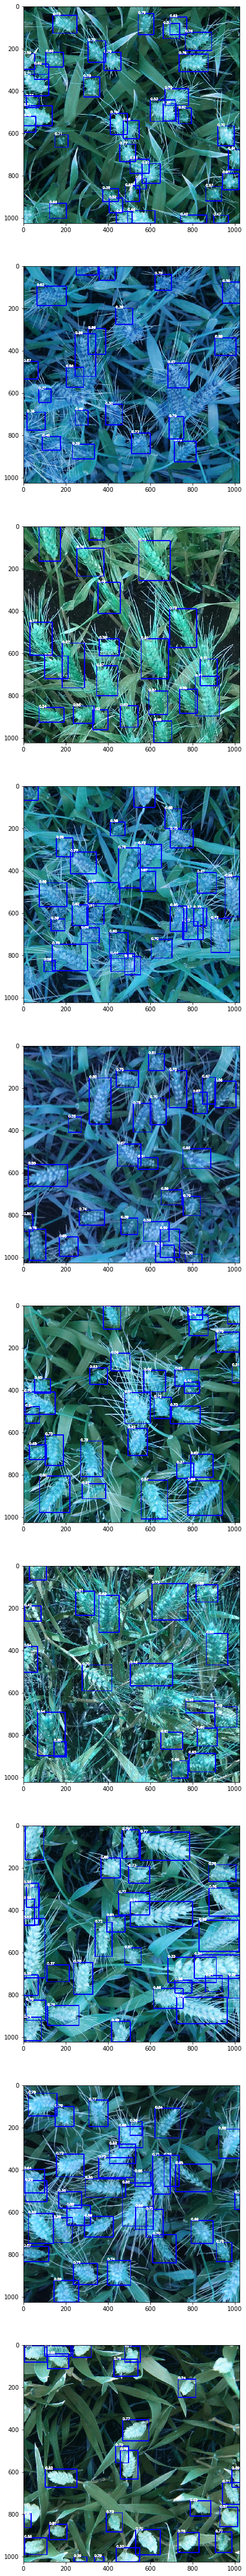

In [10]:
results = []
fig, axes = plt.subplots(10, 1,figsize=(160,80))
for count, name in enumerate(imagenames):
    ids = name.split('.')[0] 
    imagepath = '%s/%s.jpg'%(DIR_TEST,ids)
    imgcv = cv2.imread(imagepath)
    img = cv2.resize(imgcv, (input_size, input_size))
    predict0 = np.zeros((pred_out_h,pred_out_w,5))
    for i,weight in enumerate(weights_list):
        model.load_weights(weight)
        predict0 = predict0+ model.predict((img[np.newaxis])/255).reshape(pred_out_h,pred_out_w,5)
    predict0  = predict0/(i+1)
    #print(img.shape)
    print_h, print_w = imgcv.shape[:2]
    #print(predict.shape)

    
    box_and_score=NMS_all(predict0,category_n, pred_out_h, pred_out_w, score_thresh=0.25,iou_thresh=0.5)
    if len(box_and_score)==0:
        print('no boxes found!!')
        #return
        result = {
                'image_id': ids,
                'PredictionString': ''
            }

        results.append(result)
    else:

        #heatmap=predict[:,:,2]

        box_and_score=box_and_score*[1,1,print_h/pred_out_h,print_w/pred_out_w,print_h/pred_out_h,print_w/pred_out_w]
        # img=draw_rectangle(box_and_score[:,2:],img,"red")
        # img=draw_rectangle(true_boxes,img,"blue")
        preds, scores = visualize(box_and_score,imgcv)

        result = {
                'image_id': ids,
                'PredictionString': format_prediction_string(preds, scores)
            }

        results.append(result)
    

    
    # #axes[0].set_axis_off()
    if count <10:
        axes[count].imshow(imgcv)
    # #axes[1].set_axis_off()
    # axes[1].imshow(heatmap)#, cmap='gray')
    # #axes[2].set_axis_off()
    # #axes[2].imshow(heatmap_1)#, cmap='gray')
plt.show()
    #break

In [11]:
results[:5]

[{'image_id': '348a992bb',
  'PredictionString': '0.2545 530 811 49 50 0.4137 661 459 61 81 0.4197 0 518 57 76 0.4465 742 985 123 39 0.4605 492 964 129 58 0.4706 898 986 69 38 0.5233 438 969 76 55 0.5241 404 905 65 68 0.5252 661 80 77 71 0.5275 503 720 90 68 0.5572 13 425 60 52 0.5938 0 223 53 74 0.5943 374 860 74 61 0.5945 471 537 75 86 0.6073 560 742 85 92 0.6125 967 675 57 96 0.6181 692 49 80 83 0.6218 732 480 61 73 0.6219 51 272 67 71 0.6255 600 441 117 101 0.6482 481 847 67 73 0.6573 123 929 79 71 0.6667 861 850 75 68 0.6687 941 787 76 79 0.6796 106 215 82 71 0.6966 668 388 111 79 0.6972 380 216 81 85 0.7000 304 162 84 101 0.7004 917 564 78 93 0.7049 410 504 81 100 0.7051 148 606 63 58 0.7070 1 320 117 101 0.7084 1 468 135 94 0.7349 139 41 114 85 0.7578 735 224 137 84 0.7614 764 121 125 86 0.7715 455 650 74 82 0.7765 284 332 77 94 0.7913 542 33 73 99'},
 {'image_id': '796707dd7',
  'PredictionString': '0.2735 71 580 58 63 0.2978 387 652 80 97 0.3453 358 1 75 64 0.3486 231 841 105 

In [12]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.head()


image_id                                   PredictionString
0  348a992bb  0.2545 530 811 49 50 0.4137 661 459 61 81 0.41...
1  796707dd7  0.2735 71 580 58 63 0.2978 387 652 80 97 0.345...
2  aac893a91  0.4585 352 266 105 146 0.4713 311 2 71 65 0.50...
3  f5a1f0358  0.2548 478 808 75 86 0.2699 752 642 71 84 0.32...
4  cb8d261a3  0.2548 212 336 61 71 0.2974 623 941 90 79 0.30...

In [13]:
test_df.to_csv('submission.csv', index=False)